In [97]:
from printrun.printcore import printcore
from printrun import gcoder
import time
import pyvisa
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

## Connect to Devices

##### Scope

In [98]:
rm = pyvisa.ResourceManager()
rm.list_resources()
scope = rm.open_resource('USB0::0x1AB1::0x044D::DHO8A254404063::INSTR')
print(f'Scope: {scope.query('*IDN?')}')

Scope: RIGOL TECHNOLOGIES,DHO804,DHO8A254404063,00.01.01



##### 3D Printer

In [ ]:
# Connect to printer
p = printcore("COM3", 115200)

ERROR:root:Can't read from printer (disconnected?) Unable to read from serial port 'COM3'


## Set Up

##### Scope

In [100]:
scope.write(":TIM:SCAL 0.00001")  # Set timebase to 10 us/div
scope.write(":CHAN1:OFFS 0")
scope.write(":CHAN1:SCAL 0.5")    # Set CH1 voltage scale to 200mV/div
scope.write(":ACQ:TYPE AVER")
scope.write(":ACQ:AVER 4")
# scope.write(":TRIG:LEV 0.5")    # Set trigger level to 0.5V

13

##### 3D Printer

In [12]:
p.send("G91") # set to relative mode
p.send("G28") # Home
p.wait
p.send("G1 X118 Y68 Z280 F12000") # Measurement Starting Location

## Measurement Function

In [101]:
def measure_scope_vpp():
    measurements = np.array([float(scope.query(":MEAS:VPP? CHAN1")) for _ in range(10)])
    meas_avg = np.average(sorted(measurements)[4:])
    clear_output(wait=True)
    display(f"Vpp: {meas_avg:.5f} V")
    return meas_avg

## 3D Printer Movement and Data Acquisition

In [148]:
p.send("G28") # HOME

In [149]:
p.send("G91") # Relative mode

In [151]:
p.send("G1 X-10 Y-10 F12000") # Test Rel mode

In [105]:
p.send("G1 Z20 F1000")

In [94]:
p.send("G90") # Absolute mode

In [152]:
p.send("G1 X150 Y100 Z440 F12000") # Starting location

In [31]:
# DEBUGGING
p.send("G90") # Absolute position
p.send("G1 X118 Y68 Z280 F12000") # Measurement Starting Location

In [158]:
# MOVE DOWN TO PUT TANK ON
p.send("G1 Z-20 F12000")

In [160]:
# Center Tx and Rx (find max signal)
p.send("G1 X10 F6000")

In [161]:
p.send("G1 Y10 F6000")

In [147]:
p.send("G1 Z100 F12000")

In [162]:
# Move to starting point (x moves back by 32, y moves back by 32)
p.send("G1 X-50 Y-50 F6000")
p.wait

0

In [59]:
# DEBUG: Move Z back up to initial plane
p.send("G1 Z5 F1000")

In [52]:
p.send("G1 Y-1 F12000")

In [57]:
p.send("G90")

In [ ]:
p.send("G1 X150 Y100 Z280 F12000")

In [163]:
z_planes = 1
y_points = 50
x_points = 50
x_range = 100 # mm
y_range = 100 # mm
x_movement = x_range / x_points 
y_movement = y_range / y_points
measurements = np.zeros((z_planes, y_points + 1, x_points + 1))
for i in range(z_planes): # Z
    for j in range(y_points): # Y 
        for k in range(x_points): # X
            # Measure here
            measurements[i,j,k] = measure_scope_vpp()
            p.send(f"G1 X{x_movement} F3000")
            p.wait
        # Measure last x point 
        measurements[z_planes - 1, j, x_points] = measure_scope_vpp()
        p.send(f"G1 X-{x_range} Y{y_movement} F3000")
        time.sleep(3)
        p.wait
    p.send(f"G1 Y-{y_range} Z10 F3000")
    time.sleep(5)
    p.wait
print(measurements)

'Vpp: 0.03736 V'

[[[0.031989   0.03933333 0.0357     ... 0.05818883 0.060111   0.06250017]
  [0.05872233 0.0723555  0.04750017 ... 0.04322233 0.04083333 0.05154433]
  [0.0772335  0.06286667 0.063911   ... 0.03925567 0.0498775  0.04357783]
  ...
  [0.05029983 0.0639445  0.0572335  ... 0.06372233 0.05547767 0.027378  ]
  [0.07298883 0.06681183 0.0523555  ... 0.05487783 0.0476     0.03735567]
  [0.         0.         0.         ... 0.         0.         0.        ]]]


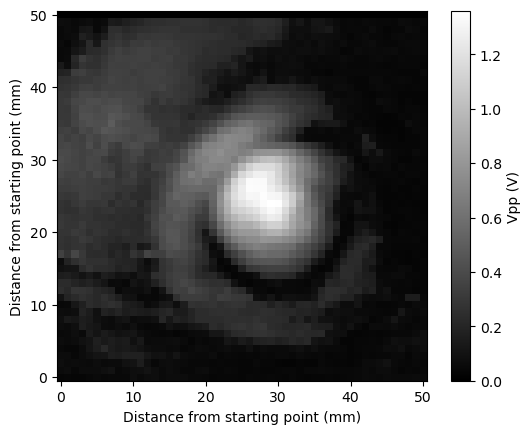

In [164]:
# Plot heatmap
plt.imshow(measurements[0], cmap="gray", interpolation="nearest", origin="lower")
plt.xlabel("Distance from starting point (mm)")
plt.ylabel("Distance from starting point (mm)")

# Add colorbar
plt.colorbar(label="Vpp (V)")

# Show heatmap
plt.show()